In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn

seaborn.set_style("darkgrid")
plt.rc("figure", figsize=(16, 10))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

In [14]:
from sqlalchemy import create_engine

engine = create_engine('mysql+pymysql://localhost', connect_args={'read_default_file': '~/.mytest.cnf'})
conn = engine.connect()

In [15]:
import pandas as pd

SQL_query = pd.read_sql_query(
    '''select tradedate, pct_close from useq.USEQ_HIST where symbol='MS'
    and volume>0 order by tradedate''',
    conn,
    index_col='tradedate'
)

df = pd.DataFrame(SQL_query, columns=['pct_close'])

df.head()


,pct_close
tradedate,
2011-01-03,0.000000
2011-01-04,0.850159
2011-01-05,1.264490
2011-01-06,-0.104061
2011-01-07,-2.083330


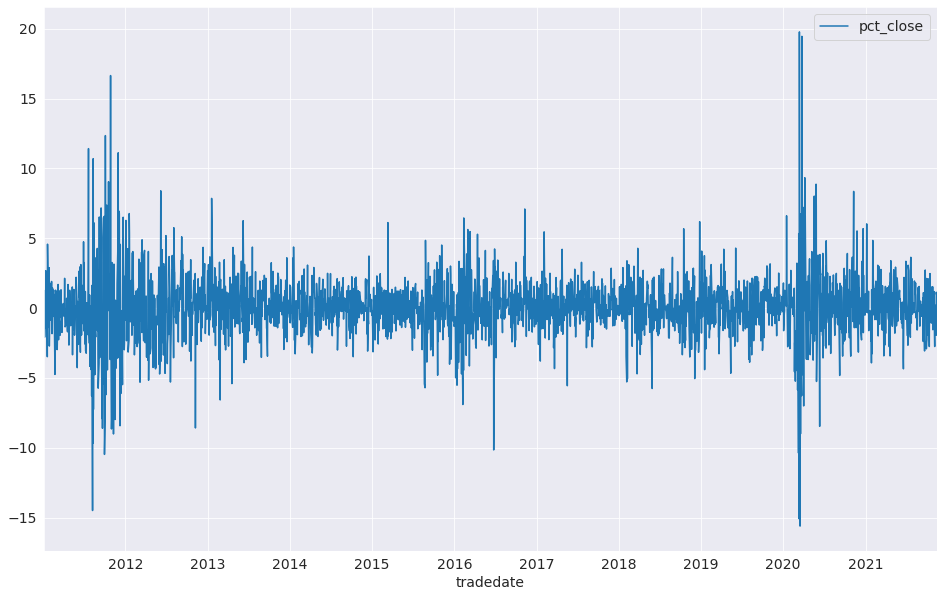

In [16]:
ax = df.plot()
xlim = ax.set_xlim(df.index.min(), df.index.max())


In [17]:
from arch import arch_model

am = arch_model(df, rescale=False, p=1, o=1, q=1, dist="StudentsT")
resg = am.fit(update_freq=5)
print(resg.summary())

Iteration:      5,   Func. Count:     52,   Neg. LLF: 5482.783503273064
Iteration:     10,   Func. Count:     97,   Neg. LLF: 5482.572280561186
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5482.572269398534
            Iterations: 11
            Function evaluations: 105
            Gradient evaluations: 11
                      Constant Mean - GJR-GARCH Model Results                       
Dep. Variable:                    pct_close   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -5482.57
Distribution:      Standardized Student's t   AIC:                           10977.1
Method:                  Maximum Likelihood   BIC:                           11012.6
                                              No. Observations:                 2733
Date:                      Sun, Nov 14 2021   Df R

In [18]:
#fig = res.plot(annualize="D")

In [19]:
from arch.univariate import ARX, HARX, HARCH, GARCH, StudentsT, SkewStudent

am=ARX(df, rescale=False, lags=[1,5,22], constant=True)
am.volatility = GARCH(1,1,1)
am.distribution = StudentsT()
resx = am.fit(update_freq=5)
print(resx.summary())

Iteration:      5,   Func. Count:     71,   Neg. LLF: 5432.969965078284
Iteration:     10,   Func. Count:    135,   Neg. LLF: 5432.276918255313
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5432.244547612293
            Iterations: 14
            Function evaluations: 183
            Gradient evaluations: 14
                            AR - GJR-GARCH Model Results                            
Dep. Variable:                    pct_close   R-squared:                       0.006
Mean Model:                              AR   Adj. R-squared:                  0.004
Vol Model:                        GJR-GARCH   Log-Likelihood:               -5432.24
Distribution:      Standardized Student's t   AIC:                           10882.5
Method:                  Maximum Likelihood   BIC:                           10935.6
                                              No. Observations:                 2711
Date:                      Sun, Nov 14 2021   Df R

In [20]:
am.distribution = SkewStudent()
resk = am.fit(update_freq=5)
print(resk.summary())

Iteration:      5,   Func. Count:     75,   Neg. LLF: 5432.968275651212
Iteration:     10,   Func. Count:    144,   Neg. LLF: 5432.1735832917675
Iteration:     15,   Func. Count:    209,   Neg. LLF: 5432.138104645144
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5432.13810464515
            Iterations: 15
            Function evaluations: 209
            Gradient evaluations: 15
                               AR - GJR-GARCH Model Results                              
Dep. Variable:                         pct_close   R-squared:                       0.006
Mean Model:                                   AR   Adj. R-squared:                  0.004
Vol Model:                             GJR-GARCH   Log-Likelihood:               -5432.14
Distribution:      Standardized Skew Student's t   AIC:                           10884.3
Method:                       Maximum Likelihood   BIC:                           10943.3
                                 

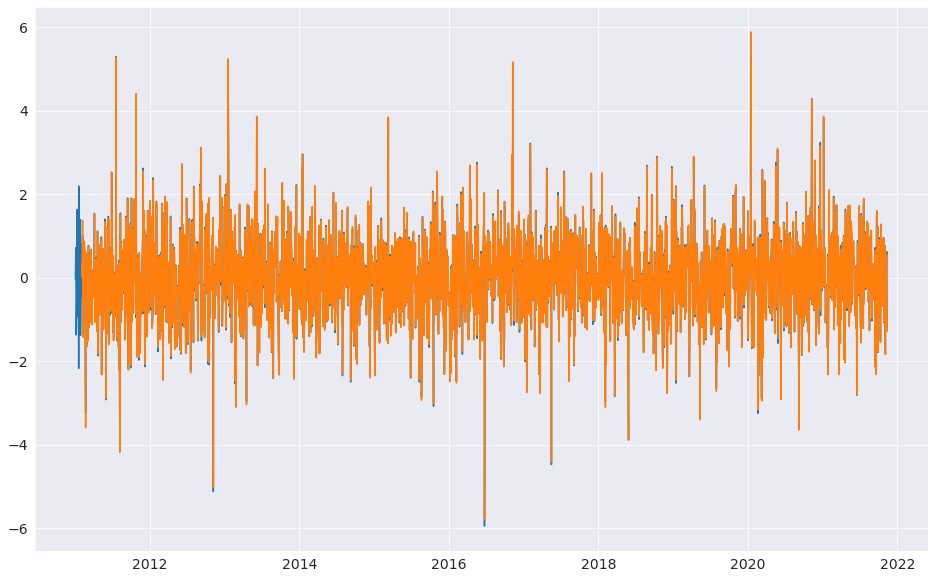

In [21]:
plt.plot(resg.std_resid, label='GJR')
plt.plot(resx.std_resid, label='ARX')

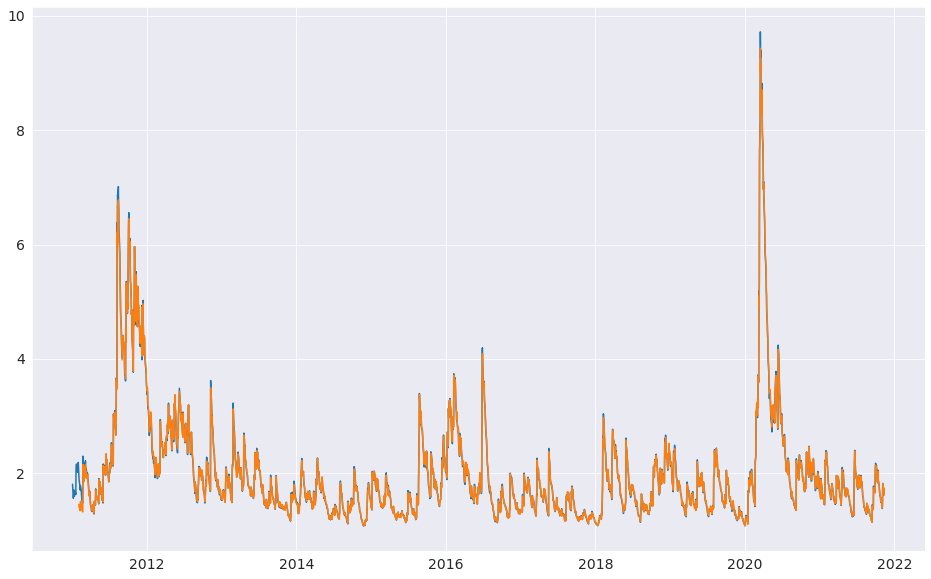

In [22]:
ax = plt.plot(resg.conditional_volatility, label='GJR')
plt.plot(resx.conditional_volatility, label='ARX')

In [23]:
am.volatility = HARCH(lags=[1,5,22])
am.distribution = StudentsT()
res = am.fit(update_freq=5)
print(res.summary())
am.distribution = SkewStudent()
res = am.fit(update_freq=5)
print(res.summary())

Iteration:      5,   Func. Count:     69,   Neg. LLF: 5469.125972879044
Iteration:     10,   Func. Count:    131,   Neg. LLF: 5450.911340212471
Iteration:     15,   Func. Count:    189,   Neg. LLF: 5448.6764167888805
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 5448.676357156256
            Iterations: 17
            Function evaluations: 211
            Gradient evaluations: 17
                              AR - HARCH Model Results                              
Dep. Variable:                    pct_close   R-squared:                       0.006
Mean Model:                              AR   Adj. R-squared:                  0.005
Vol Model:                            HARCH   Log-Likelihood:               -5448.68
Distribution:      Standardized Student's t   AIC:                           10915.4
Method:                  Maximum Likelihood   BIC:                           10968.5
                                              No. Observations

In [24]:
print("Log-Likelihood = ", resg.loglikelihood, " for GJR")
print("Log-Likelihood = ", resx.loglikelihood, " for ARX")
print("nobs = ", resg.nobs, " for GJR")
print ("nobs = ", resx.nobs, " for ARX")
factor = resg.nobs / resx.nobs
adjusted = resx.loglikelihood * factor
print("Log-Likelihood adjusted = ", adjusted, " for ARX")


Log-Likelihood =  -5482.572269398534  for GJR
Log-Likelihood =  -5432.244547612293  for ARX
nobs =  2733  for GJR
nobs =  2711  for ARX
Log-Likelihood adjusted =  -5476.327683004203  for ARX
